# Section 1 : Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import plotly.graph_objects as go
import plotly.express as px

# Section 2 : Read Data

In [3]:
# Fetching MNIST
mnist = pd.read_csv("mnist_train.csv")

#By dividing by 255, the 0-255 range can be described with a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).
X = mnist.drop("label",axis=1)/255
y = mnist.label

# Print Shape
print(X.shape, y.shape)

(42000, 784) (42000,)


In [4]:
#Columns 
mnist.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [5]:
#Show Data
mnist.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

#### We are going to convert the matrix and vector to a Pandas DataFrame. This is very similar to the DataFrames used in R and will make it easier for us to plot it later on.

In [6]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (42000, 786)


#### To ensure randomisation we’ll create a random permutation of the number 0 to 69,999 which allows us later to select the first five or ten thousand for our calculations and visualisations.

In [7]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [8]:
rndperm

array([ 5457, 38509, 25536, ..., 38158,   860, 15795])

#### Lets first check what these numbers actually look like. To do this we’ll generate 30 plots of randomly selected images.

<Figure size 432x288 with 0 Axes>

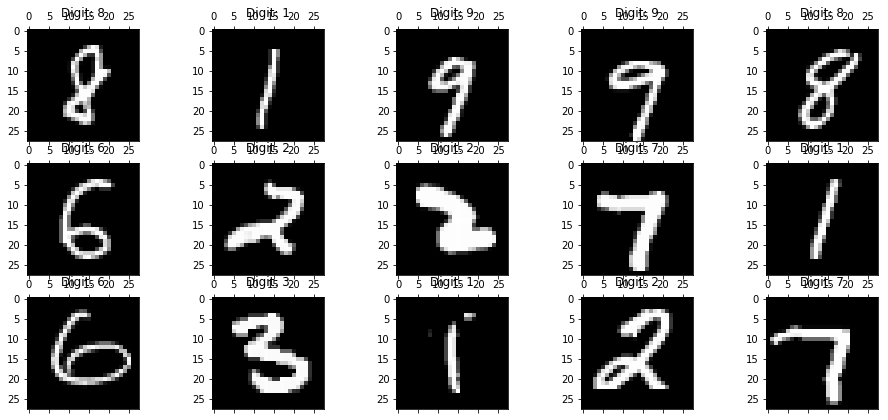

In [9]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

# Section 3: Applying PCA

#### The images are all essentially 28-by-28 pixel images and therefore have a total of 784 ‘dimensions’, each holding the value of one specific pixel.
What we can do is reduce the number of dimensions drastically whilst trying to retain as much of the ‘variation’ in the information as possible. This is where we get to dimensionality reduction. Lets first take a look at something known as Principal Component Analysis.

In [10]:
#The first three principal components. 
#And we’ll also see how much of the variation in the total dataset they actually account for.

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09748938 0.07160266 0.06145903]


#### What we can do is create a scatterplot of the first and second principal component and color each of the different types of digits with a different color. If we are lucky the same type of digits will be positioned (i.e., clustered) together in groups, which would mean that the first two principal components actually tell us a great deal about the specific types of digits.

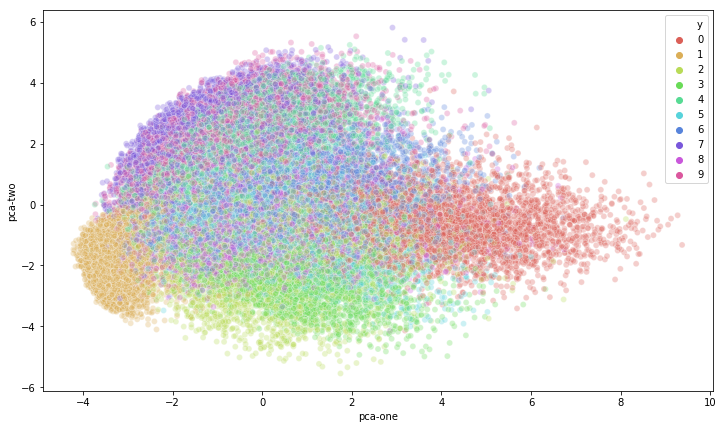

In [11]:
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

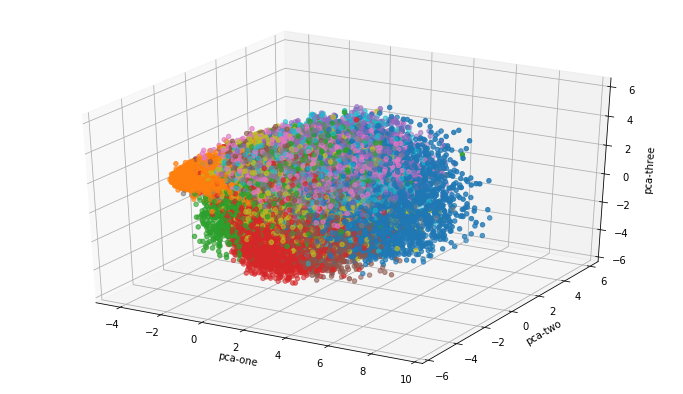

In [12]:
#3D Version of same plot above
ax = plt.figure(figsize=(12,7)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Section 4:  T-Distributed Stochastic Neighbouring Entities (t-SNE)

#### t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding

Contrary to the recommendation above we will first try to run the algorithm on the actual dimensions of the data (784) and see how it does. To make sure we don’t burden our machine in terms of memory and power/time we will only use the first 10,000 samples to run the algorithm on. To compare later on I’ll also run the PCA again on the subset.

In [13]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09652717 0.07299609 0.06045867]


In [14]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 2.202s...
[t-SNE] Computed neighbors for 10000 samples in 235.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.131615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.375206
[t-SNE] KL divergence after 300 iterations: 2.795638
t-SNE done! Time elapse

#### Lets visualize

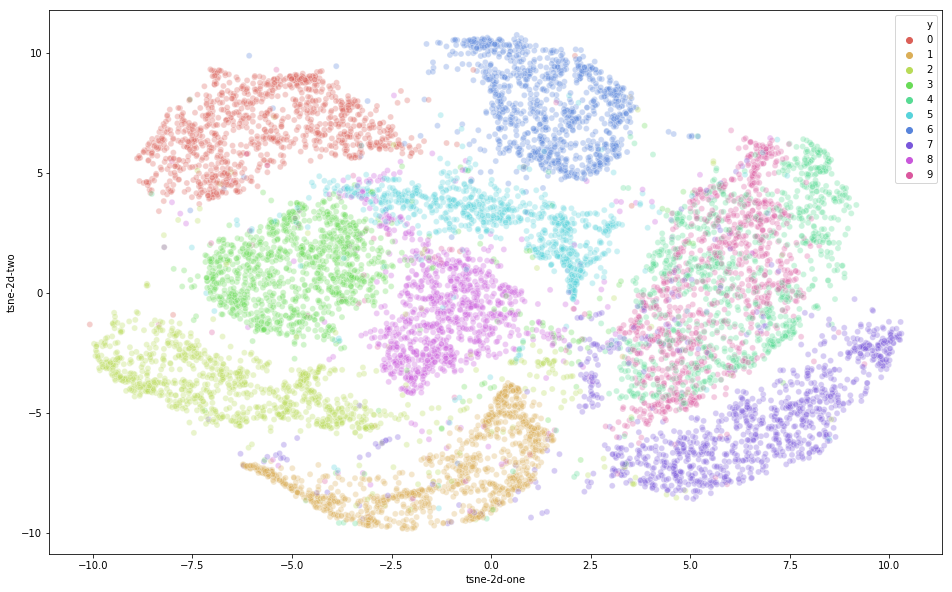

In [15]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

#### This is already a significant improvement over the PCA visualisation we used earlier. We can see that the digits are very clearly clustered in their own sub groups. If we would now use a clustering algorithm to pick out the seperate clusters we could probably quite accurately assign new points to a label. Just to compare PCA & T-SNE:

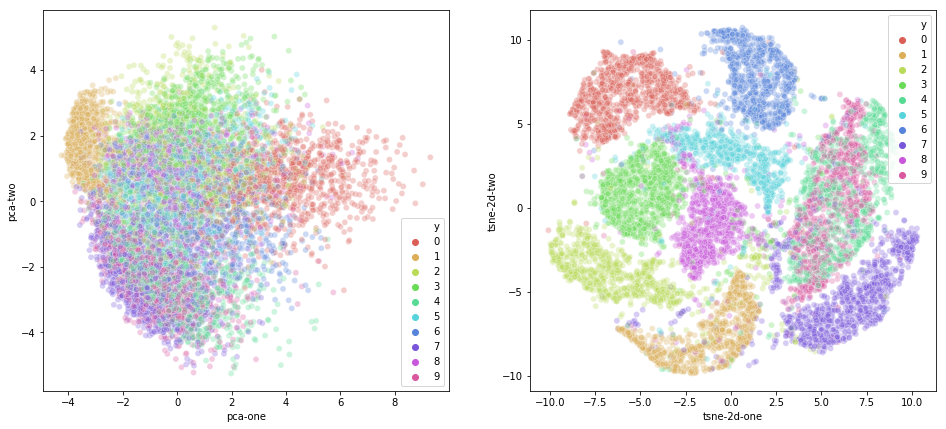

In [16]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

#### We’ll now take the recommendations to heart and actually reduce the number of dimensions before feeding the data into the t-SNE algorithm. For this we’ll use PCA again. We will first create a new dataset containing the fifty dimensions generated by the PCA reduction algorithm. We can then use this dataset to perform the t-SNE on

In [17]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8261086943201882


#### Amazingly, the first 50 components roughly hold around 85% of the total variation in the data.
Now lets try and feed this data into the t-SNE algorithm. This time we’ll use 10,000 samples out of the 42K data to make sure the algorithm does not take up too much memory and CPU. Since the code used for this is very similar to the previous t-SNE code

In [18]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 81.44458961486816 seconds


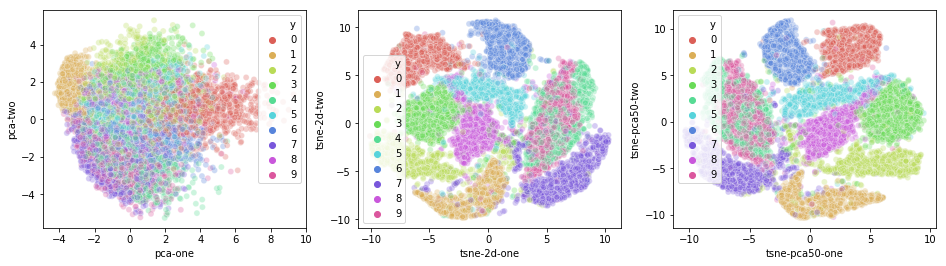

In [19]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

### Hope you guys understood which one to use.

### Lets Plot Numbers as well.

In [20]:
## Loading and curating the data
digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target

#### Let’s define the plotting function to use later. This simple function mainly does three things. At first, it scales the values to fit the plot. Then it formats the data point representation so that each data point will show as a colored text. Finally it adds an AnnotationBox for some samples which shows the corresponding image of the data point.

In [21]:
## Function to Scale and plot the MNIST data
def plot_MNIST(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min) # scale the values to fit    
    plt.figure(figsize= (10,10)) #fig size
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9}) 
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 5e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

#### Then we use the sklearn function to compute the PCA, as you can guess, the “n_components=2” indicates the result should consist of 2 dimensions.

Computing PCA projection


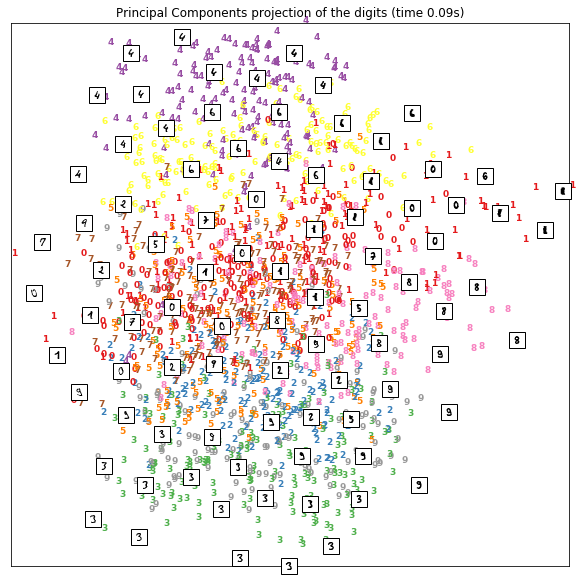

In [22]:
## Computing PCA
print("Computing PCA projection")
t0 = time.time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_MNIST(X_pca,"Principal Components projection of the digits (time %.2fs)" %(time.time() - t0))
plt.show()

#### Let’s try t-SNE then. Again we use a sklearn pre-built function for computing t-SNE, besides our old friend “n_components”, there is another parameter “init=’pca’”, this is to initialize the distribution with pca to better keep the global structure of the distribution.

Computing t-SNE embedding


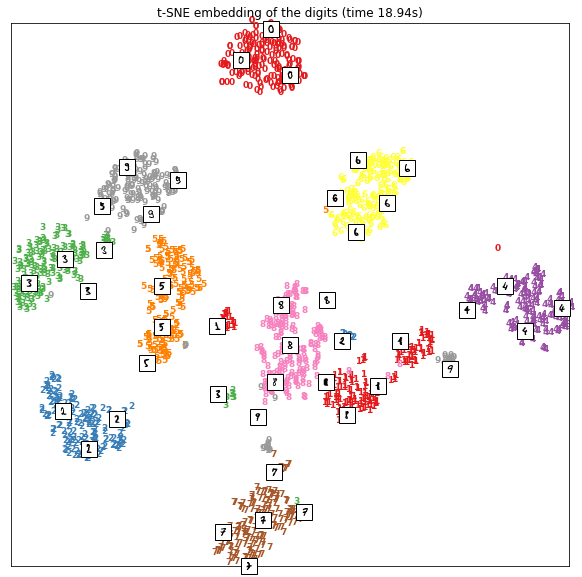

In [23]:
print("Computing t-SNE embedding")
t0 = time.time()
X_tsne = manifold.TSNE(n_components=2, init='pca').fit_transform(X)
plot_MNIST(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time.time() - t0))
plt.show()

# Section 5: Parallel Coordinates Plots

#### Plotly Express is the easy-to-use, high-level interface to Plotly, which operates on "tidy" data and produces easy-to-style figures. In a parallel coordinates plot with px.parallel_coordinates, each row of the DataFrame is represented by a polyline mark which traverses a set of parallel axes, one for each of the dimensions. For other representations of multivariate data, also see parallel categories, radar charts and scatterplot matrix (SPLOM).

In [24]:
df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/iris.csv")
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['species_id'],
                   colorscale = [[0,'purple'],[0.5,'lightseagreen'],[1,'gold']]),
        dimensions = list([
            dict(range = [0,8],
                constraintrange = [4,8],
                label = 'Sepal Length', values = df['sepal_length']),
            dict(range = [0,8],
                label = 'Sepal Width', values = df['sepal_width']),
            dict(range = [0,8],
                label = 'Petal Length', values = df['petal_length']),
            dict(range = [0,8],
                label = 'Petal Width', values = df['petal_width'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [26]:
df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['colorVal'],
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(range = [32000,227900],
                 constraintrange = [100000,150000],
                 label = "Block Height", values = df['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = df['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = df['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = df['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = df['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = df['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = df['HstW'])])
    )
)
fig.show()